In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F

In [2]:
colab = True
if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)
  %cp "/content/drive/My Drive/autoencoder-training/data.zip" .
  !unzip -q data.zip
  image_path = "data"
else: 
  os.chdir("../")
  image_path = os.getcwd() + "/data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data

In [0]:
np.random.seed(3333)
torch.manual_seed(3333)

size = 32
batchsize = 128

tfms = get_transforms(do_flip = True)
src = (ImageImageList.from_folder(image_path).use_partial_data(0.1).split_by_folder().label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))

In [4]:
data

ImageDataBunch;

Train: LabelList (5007 items)
x: ImageImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: data;

Valid: LabelList (993 items)
x: ImageImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: data;

Test: None

# Learner

## Model

In [0]:
def icnr(x, scale=2, init=nn.init.kaiming_normal_):
    "ICNR init of `x`, with `scale` and `init` function."
    ni,nf,h,w = x.shape
    ni2 = int(ni/(scale**2))
    k = init(torch.zeros([ni2,nf,h,w])).transpose(0, 1)
    k = k.contiguous().view(ni2, nf, -1)
    k = k.repeat(1, 1, scale**2)
    k = k.contiguous().view([nf,ni,h,w]).transpose(0, 1)
    x.data.copy_(k)

class PixelShuffle_ICNR(nn.Module):
    "Upsample by `scale` from `ni` filters to `nf` (default `ni`), using `nn.PixelShuffle`, `icnr` init, and `weight_norm`."
    def __init__(self, ni:int, nf:int=None, scale:int=2, blur:bool=False, norm_type=NormType.Weight, leaky:float=None):
        super().__init__()
        nf = ifnone(nf, ni)
        self.conv = conv_layer(ni, nf*(scale**2), ks=1, norm_type=norm_type, use_activ=False)
        icnr(self.conv[0].weight)
        self.shuf = nn.PixelShuffle(scale)
        # Blurring over (h*w) kernel
        # "Super-Resolution using Convolutional Neural Networks without Any Checkerboard Artifacts"
        # - https://arxiv.org/abs/1806.02658
        self.pad = nn.ReplicationPad2d((1,0,1,0))
        self.blur = nn.AvgPool2d(2, stride=1)
        self.relu = relu(True, leaky=leaky)

    def forward(self,x):
        x = self.shuf(self.relu(self.conv(x)))
        return self.blur(self.pad(x)) if self.blur else x

In [0]:
class Encoder1(nn.Module):
    def __init__(self):
        super(Encoder1, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[0:3]))
        for param in resnet.parameters():
            param.requires_grad = False

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[3:5]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[1][i].bn1.parameters():
                param.requires_grad = True
            for param in resnet[1][i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class Encoder3(nn.Module):
    def __init__(self):
        super(Encoder3, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[5]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class Encoder4(nn.Module):
    def __init__(self):
        super(Encoder4, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[6]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class Encoder5(nn.Module):
    def __init__(self):
        super(Encoder5, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[7]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class AdaptiveConcatPool2d(Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz:Optional[int]=None):
        "Output will be 2*sz or 2 if sz is None"
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

class Encoder6(nn.Module):
    def __init__(self):
        super(Encoder6, self).__init__()

        self.encoder = nn.Sequential(AdaptiveConcatPool2d())

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class Decoder1(nn.Module):
    def __init__(self):
        super(Decoder1, self).__init__()

        self.decoder = nn.Sequential( 
            PixelShuffle_ICNR(64, 3),
            nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )

    def decode(self,x): return self.decoder(x)

    def forward(self, x):
      decoded = self.decoder(x)
      return decoded

class Decoder2(nn.Module):
    def __init__(self):
        super(Decoder2, self).__init__()

        self.decoder = nn.Sequential( 
            PixelShuffle_ICNR(64, 64),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def decode(self,x): return self.decoder(x)

    def forward(self, x):
      decoded = self.decoder(x)
      return decoded

class Decoder3(nn.Module):
    def __init__(self):
        super(Decoder3, self).__init__()

        self.decoder = nn.Sequential( 
            PixelShuffle_ICNR(128, 64),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def decode(self,x): return self.decoder(x)

    def forward(self, x):
      decoded = self.decoder(x)
      return decoded

class Decoder4(nn.Module):
    def __init__(self):
        super(Decoder4, self).__init__()

        self.decoder = nn.Sequential( 
            PixelShuffle_ICNR(256, 128),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def decode(self,x): return self.decoder(x)

    def forward(self, x):
      decoded = self.decoder(x)
      return decoded

class Decoder5(nn.Module):
    def __init__(self):
        super(Decoder5, self).__init__()

        self.decoder = nn.Sequential( 
            PixelShuffle_ICNR(512, 256),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def decode(self,x): return self.decoder(x)

    def forward(self, x):
      decoded = self.decoder(x)
      return decoded


class Decoder6(nn.Module):
    def __init__(self):
        super(Decoder6, self).__init__()

        self.decoder = nn.Sequential( 
            nn.Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )

    def decode(self,x): return self.decoder(x)

    def forward(self, x):
      decoded = self.decoder(x)
      return decoded

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(Encoder1(), 
                                     Encoder2(), 
                                     Encoder3(), 
                                     Encoder4(), 
                                     Encoder5(), 
                                     Encoder6())

        self.decoder = nn.Sequential(Decoder6(),
                                     Decoder5(),
                                     Decoder4(),
                                     Decoder3(),
                                     Decoder2(),
                                     Decoder1())

    def encode(self, x): return self.encoder(x)

    def decode(self,x): return torch.clamp(self.decoder(x), min = 0, max=1)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return torch.clamp(decoded, min = 0, max = 1)

## Learner

In [7]:
autoencoder = AutoEncoder()
learn = Learner(data, autoencoder, loss_func = F.mse_loss)

Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /root/.cache/torch/hub/v0.5.0.zip
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [0]:
%cp "drive/My Drive/autoencoder-training/stage-1-cifar_px_shuffle.pth" "data/models/"

In [0]:
learn = learn.load('stage-1-cifar_px_shuffle')

In [10]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

from torchvision.models import vgg16_bn
vgg_m = vgg16_bn(True).features.cuda().eval()

requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

from fastai.callbacks import *
from fastai.utils.mem import *

base_loss = F.mse_loss

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [0]:
learn.data.batch_size = 128

In [0]:
lr = [1e-05, 1e-02]
def do_fit(save_name, lrs=slice(lr[0], lr[1]), pct_start=0.9):
    learn.fit_one_cycle(5, lrs)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.021060,0.022555,0.022555,0.113174,00:15
1,0.021229,0.023284,0.023284,0.114680,00:15
2,0.020916,0.021366,0.021366,0.109524,00:15
3,0.020354,0.021008,0.021008,0.108820,00:15
4,0.019783,0.020975,0.020975,0.108775,00:15


epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.031693,0.033603,0.022578,0.112167,00:15
1,0.031824,0.033447,0.022616,0.112352,00:15
2,0.031006,0.032501,0.021846,0.110452,00:15
3,0.030114,0.031576,0.021138,0.109190,00:15
4,0.029477,0.031381,0.020965,0.108260,00:15


epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.041813,0.044840,0.023310,0.115280,00:15
1,0.041620,0.044711,0.023603,0.115460,00:15
2,0.040599,0.042780,0.022262,0.111471,00:15
3,0.039676,0.042285,0.022093,0.110871,00:15
4,0.038870,0.041333,0.021368,0.109453,00:15


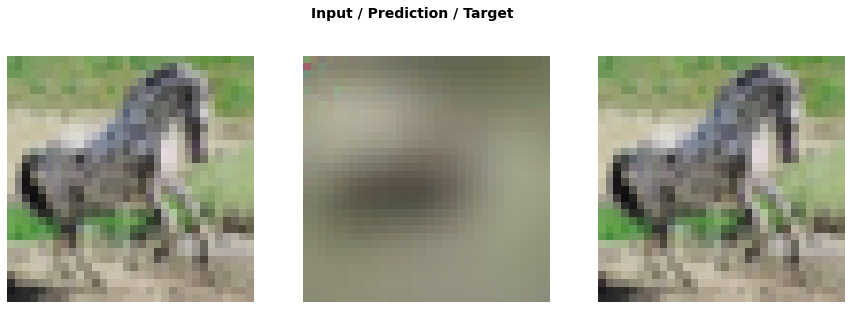

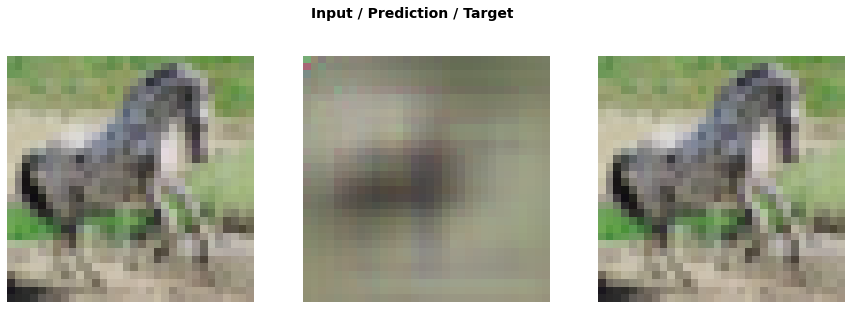

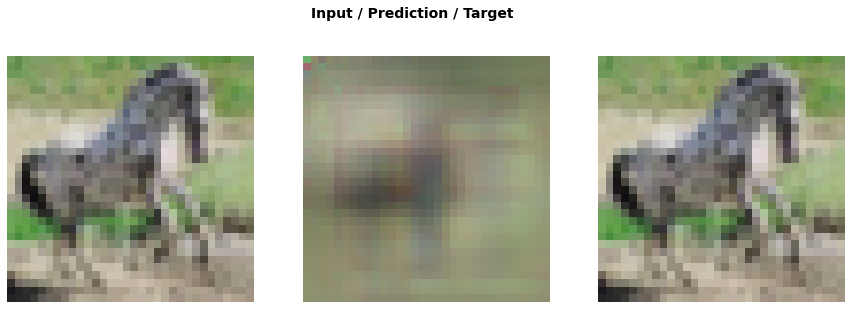

In [53]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

for i in np.arange(0,1.1, 0.5):
  learn = learn.load('stage-1-cifar_px_shuffle')
  learn.data.batch_size = 128
  learn.metrics = [mse, mae]
  learn.split(lambda m: (m.encoder[1], m.encoder[2], m.encoder[3], m.encoder[4], m.encoder[5], m.decoder[0], m.decoder[2], m.decoder[3], m.decoder[4]))
  feat_loss = FeatureLoss(vgg_m, blocks[2:5], [i, 0, 0])
  learn.loss_func = feat_loss
  learn.unfreeze()
  do_fit('test')

0.0


epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.020941,0.022687,0.022687,0.113730,00:15
1,0.021393,0.022632,0.022632,0.113513,00:15
2,0.020986,0.021642,0.021642,0.110165,00:15
3,0.020377,0.021191,0.021191,0.109174,00:15
4,0.019858,0.021033,0.021033,0.108637,00:15


0.5


epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.025493,0.027246,0.022646,0.113637,00:15
1,0.025887,0.028495,0.023998,0.116334,00:15
2,0.025632,0.026769,0.022387,0.113238,00:15
3,0.025029,0.025837,0.021523,0.110292,00:15
4,0.024306,0.025496,0.021207,0.109156,00:15


1.0


epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.029705,0.031946,0.023059,0.114791,00:15
1,0.031889,0.038288,0.029136,0.133052,00:15
2,0.031023,0.031238,0.022917,0.114931,00:15
3,0.029645,0.030573,0.022474,0.113429,00:15
4,0.028767,0.030233,0.022215,0.112495,00:15


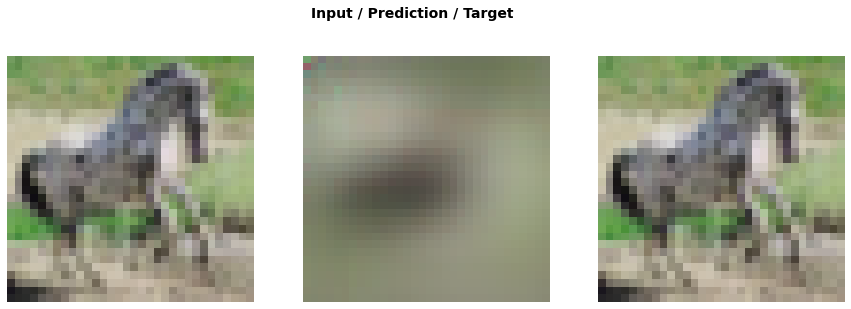

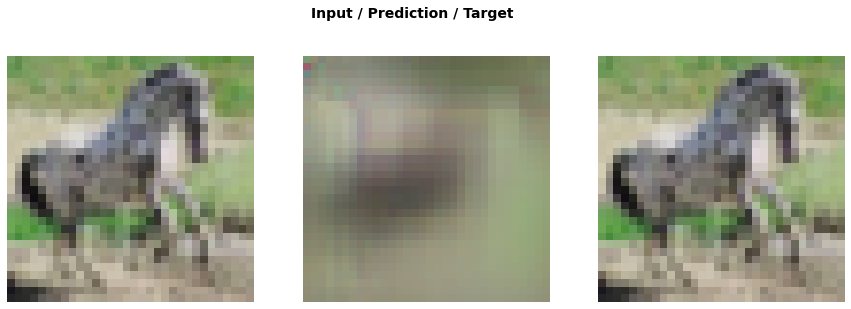

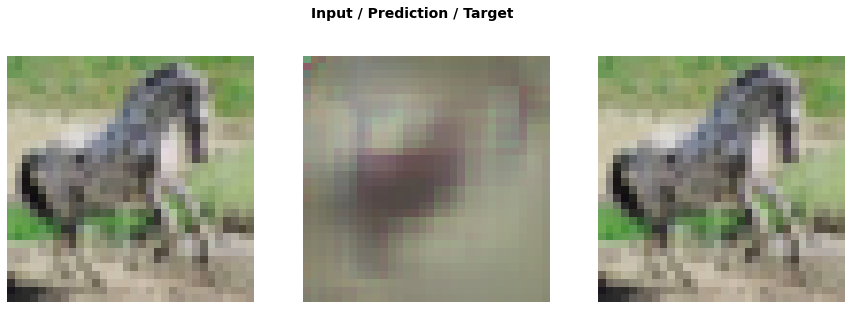

In [54]:
for i in np.arange(0,1.1, 0.5):
  print(i)
  learn = learn.load('stage-1-cifar_px_shuffle')
  learn.data.batch_size = 128
  learn.metrics = [mse, mae]
  learn.split(lambda m: (m.encoder[1], m.encoder[2], m.encoder[3], m.encoder[4], m.encoder[5], m.decoder[0], m.decoder[2], m.decoder[3], m.decoder[4]))
  feat_loss = FeatureLoss(vgg_m, blocks[2:5], [0, i, 0])
  learn.loss_func = feat_loss
  learn.unfreeze()
  do_fit('test')

0.0


epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.021183,0.022570,0.022570,0.112206,00:15
1,0.021291,0.023136,0.023136,0.113878,00:15
2,0.020990,0.021719,0.021719,0.110831,00:15
3,0.020349,0.021167,0.021167,0.108635,00:15
4,0.019852,0.020988,0.020988,0.108538,00:15


0.5


epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.056913,0.057118,0.024823,0.119780,00:15
1,0.056874,0.056609,0.026288,0.123529,00:15
2,0.053809,0.053029,0.024579,0.119301,00:15
3,0.051245,0.051628,0.023739,0.117087,00:15
4,0.049727,0.051023,0.023416,0.115913,00:15


1.0


epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.092146,0.089251,0.026616,0.125690,00:15
1,0.085573,0.083807,0.027548,0.128036,00:15
2,0.081460,0.080628,0.025987,0.122602,00:15
3,0.078135,0.078181,0.025273,0.121221,00:15
4,0.075428,0.077338,0.024802,0.119901,00:15


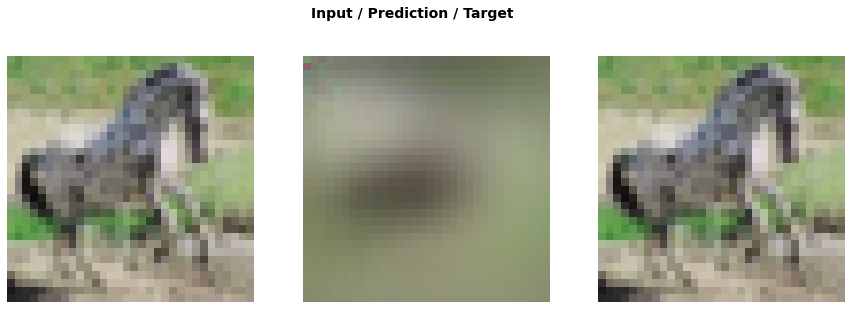

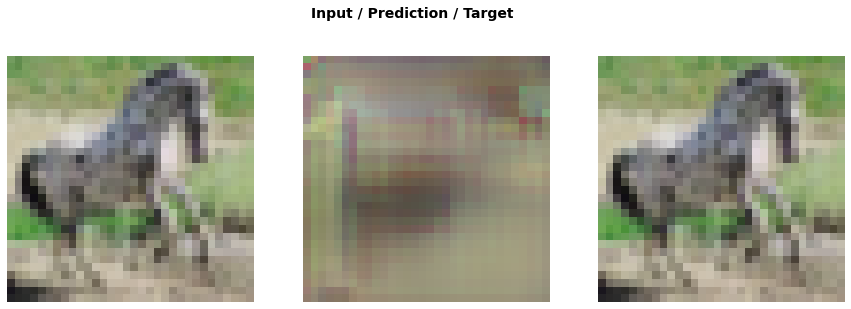

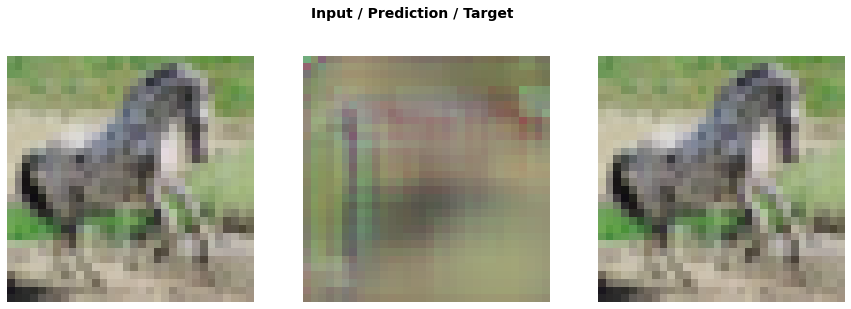

In [55]:
for i in np.arange(0,1.1, 0.5):
  print(i)
  learn = learn.load('stage-1-cifar_px_shuffle')
  learn.data.batch_size = 128
  learn.metrics = [mse, mae]
  learn.split(lambda m: (m.encoder[1], m.encoder[2], m.encoder[3], m.encoder[4], m.encoder[5], m.decoder[0], m.decoder[2], m.decoder[3], m.decoder[4]))
  feat_loss = FeatureLoss(vgg_m, blocks[2:5], [0, 0, i])
  learn.loss_func = feat_loss
  learn.unfreeze()
  do_fit('test')

0.0


epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.020930,0.022403,0.022403,0.112619,00:15
1,0.021258,0.022686,0.022686,0.112944,00:15
2,0.020909,0.021497,0.021497,0.109587,00:15
3,0.020301,0.021069,0.021069,0.108485,00:15
4,0.019657,0.020967,0.020967,0.108166,00:15


0.5


epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.023352,0.025441,0.022602,0.113402,00:15
1,0.023738,0.025491,0.022661,0.113538,00:15
2,0.023191,0.024746,0.021934,0.111588,00:15
3,0.022555,0.023857,0.021061,0.108801,00:14
4,0.021930,0.023600,0.020809,0.107861,00:14


1.0


epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.025459,0.028593,0.022899,0.114074,00:15
1,0.026200,0.029120,0.023416,0.115118,00:15
2,0.025660,0.027280,0.021649,0.110846,00:15
3,0.024900,0.026758,0.021152,0.108981,00:15
4,0.024384,0.026582,0.020980,0.108708,00:15


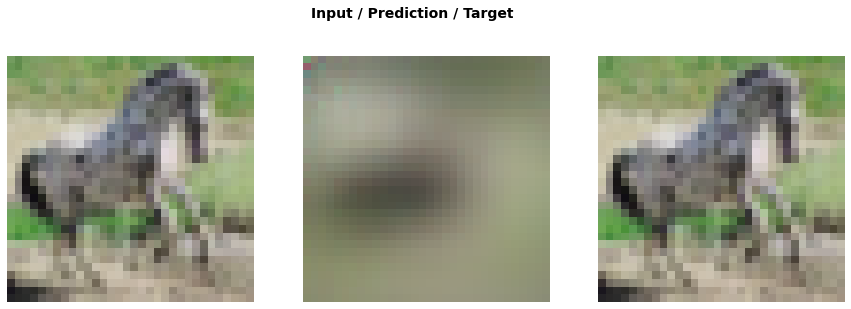

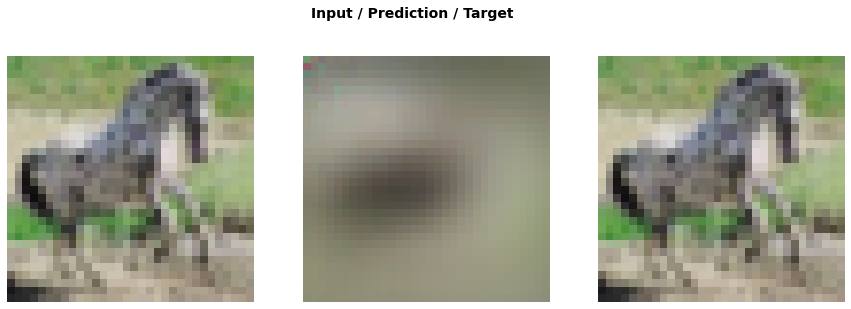

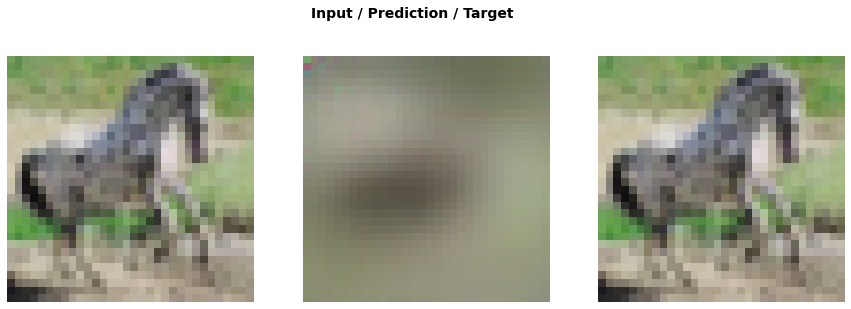

In [56]:
for i in np.arange(0,1.1, 0.5):
  print(i)
  learn = learn.load('stage-1-cifar_px_shuffle')
  learn.data.batch_size = 128
  learn.metrics = [mse, mae]
  learn.split(lambda m: (m.encoder[1], m.encoder[2], m.encoder[3], m.encoder[4], m.encoder[5], m.decoder[0], m.decoder[2], m.decoder[3], m.decoder[4]))
  feat_loss = FeatureLoss(vgg_m, blocks[0:3], [i, 0, 0])
  learn.loss_func = feat_loss
  learn.unfreeze()
  do_fit('test')

0.0


epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.020873,0.022469,0.022469,0.111894,00:16
1,0.021262,0.023578,0.023578,0.115472,00:16
2,0.020991,0.021534,0.021534,0.109660,00:15
3,0.020375,0.021352,0.021352,0.110465,00:15
4,0.019821,0.020828,0.020828,0.107951,00:15


0.5


epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.028386,0.030736,0.022429,0.113072,00:15
1,0.029077,0.031988,0.023615,0.116157,00:15
2,0.028634,0.029965,0.021760,0.110830,00:15
3,0.027819,0.029235,0.021127,0.108877,00:15
4,0.027210,0.029076,0.020980,0.108067,00:15


1.0


epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.036094,0.039333,0.022763,0.114052,00:15
1,0.036366,0.039044,0.022685,0.113513,00:15
2,0.035756,0.037947,0.021925,0.110851,00:15
3,0.035098,0.037298,0.021434,0.109871,00:15
4,0.034519,0.036933,0.021119,0.108412,00:15


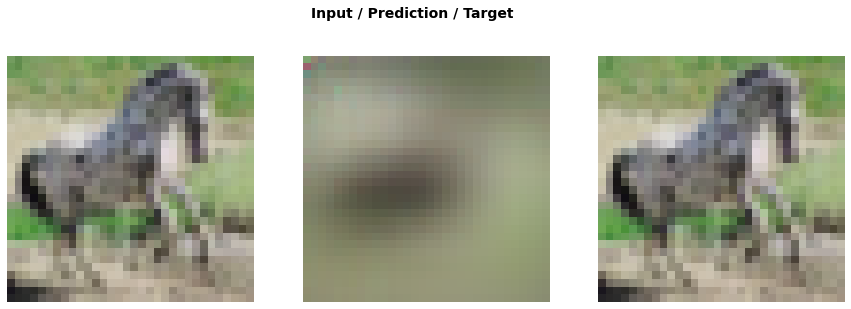

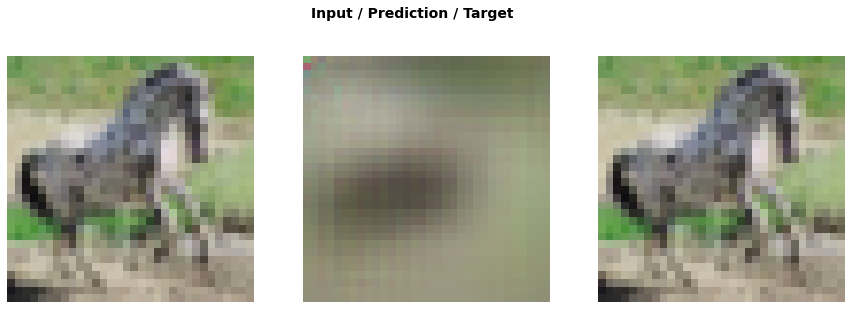

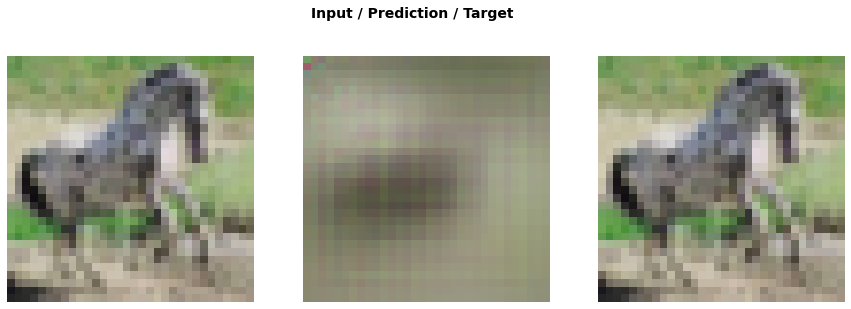

In [57]:
for i in np.arange(0,1.1, 0.5):
  print(i)
  learn = learn.load('stage-1-cifar_px_shuffle')
  learn.data.batch_size = 128
  learn.metrics = [mse, mae]
  learn.split(lambda m: (m.encoder[1], m.encoder[2], m.encoder[3], m.encoder[4], m.encoder[5], m.decoder[0], m.decoder[2], m.decoder[3], m.decoder[4]))
  feat_loss = FeatureLoss(vgg_m, blocks[0:3], [0, i, 0])
  learn.loss_func = feat_loss
  learn.unfreeze()
  do_fit('test')

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.038360,0.041676,0.023283,0.115395,00:15
1,0.038240,0.040673,0.022962,0.114357,00:15
2,0.037438,0.039675,0.022320,0.112492,00:15
3,0.036654,0.038906,0.021836,0.111185,00:15
4,0.035927,0.038806,0.021771,0.110720,00:16


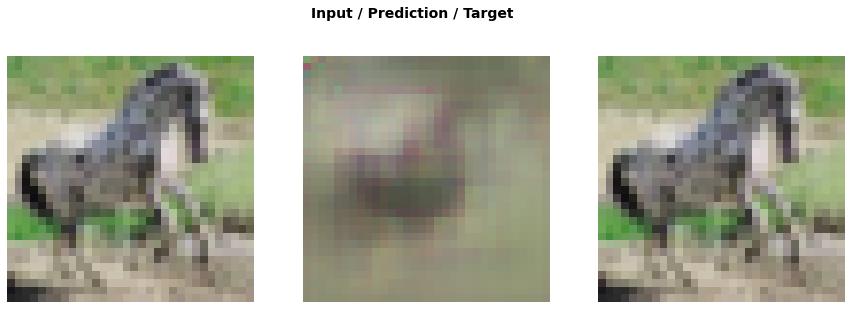

In [58]:
learn = learn.load('stage-1-cifar_px_shuffle')
learn.data.batch_size = 128
learn.metrics = [mse, mae]
learn.split(lambda m: (m.encoder[1], m.encoder[2], m.encoder[3], m.encoder[4], m.encoder[5], m.decoder[0], m.decoder[2], m.decoder[3], m.decoder[4]))
feat_loss = FeatureLoss(vgg_m, blocks, [0.5, 0, 0.3, 1, 0])
learn.loss_func = feat_loss
learn.unfreeze()
do_fit('test')

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.035243,0.038501,0.021562,0.110191,00:15
1,0.035454,0.038750,0.021751,0.110737,00:16
2,0.035882,0.039183,0.022199,0.112534,00:16
3,0.035782,0.038663,0.021836,0.110693,00:15
4,0.035543,0.038394,0.021707,0.110705,00:15
5,0.035043,0.037517,0.020943,0.108283,00:15
6,0.034585,0.037047,0.020673,0.107626,00:15
7,0.034062,0.036659,0.020354,0.106060,00:15
8,0.033555,0.036592,0.020296,0.105980,00:16
9,0.033188,0.036743,0.020452,0.106781,00:15


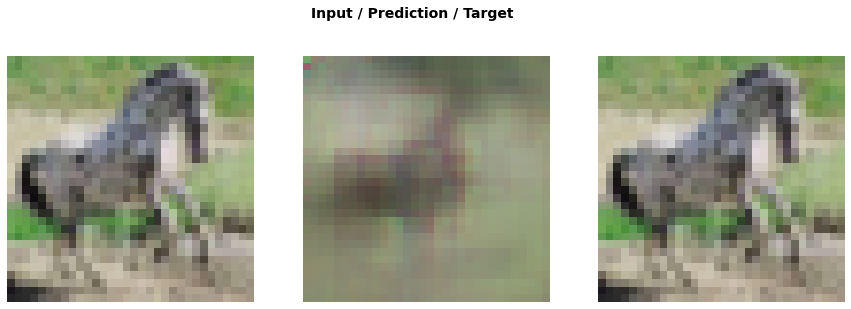

In [60]:
learn.fit_one_cycle(10, slice(lr[0],lr[1]))
learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.033140,0.036398,0.020180,0.106137,00:15
1,0.033077,0.036484,0.020259,0.106155,00:16
2,0.033165,0.036797,0.020490,0.106894,00:15
3,0.033406,0.037315,0.020875,0.108612,00:15
4,0.033464,0.037410,0.021059,0.109315,00:15
5,0.033563,0.037958,0.021622,0.109691,00:15
6,0.033325,0.036598,0.020347,0.106579,00:16
7,0.033037,0.037080,0.020880,0.106734,00:16
8,0.032677,0.036746,0.020620,0.104867,00:15
9,0.032442,0.036254,0.020248,0.105065,00:15


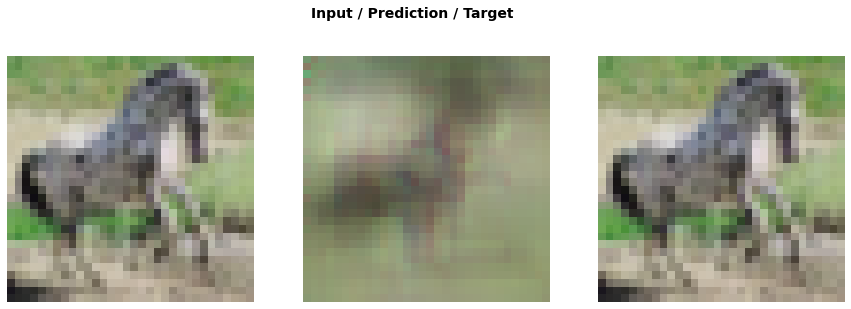

In [61]:
learn.fit_one_cycle(20, slice(lr[0],lr[1]))
learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.030120,0.034949,0.019352,0.101133,00:15
1,0.030082,0.034745,0.019131,0.100731,00:15
2,0.031264,0.036435,0.020494,0.103989,00:15
3,0.031116,0.034532,0.018830,0.100684,00:15
4,0.030861,0.034289,0.018644,0.101251,00:15
5,0.030757,0.034512,0.018865,0.101695,00:15
6,0.030856,0.035290,0.019655,0.103507,00:15
7,0.031010,0.034722,0.019010,0.103011,00:15
8,0.030883,0.034397,0.018772,0.101287,00:15
9,0.030846,0.035377,0.019680,0.102756,00:15


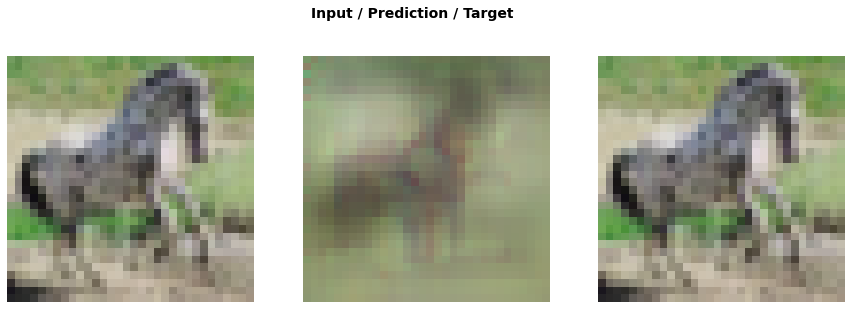

In [62]:
learn.fit_one_cycle(25, slice(lr[0], lr[1]))
learn.show_results(rows=1, imgsize=5)

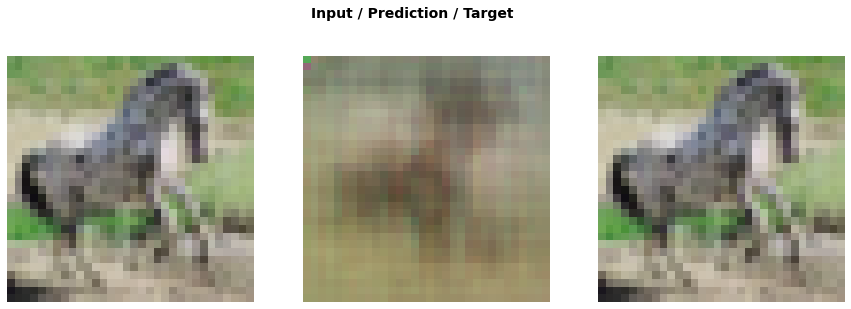

In [33]:
learn.show_results(rows=1, imgsize=5)